# PyTorch

In [1]:
# install pytorch
# ! pip3 install torch torchvision torchaudio

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision  # cnn 계열 도구
from torchvision import transforms, datasets

In [6]:
# GPU 사용 가능 여부 확인 -> GPU, CPU 선택

if torch.cuda.is_available():   # False
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# gpu가 가능하다면, gpu를 사용하고, 그렇지 않다면 cpu를 사용한다.
print(device)

cpu


### 데이터 준비

In [7]:
# 데이터 준비 1. 

# 기존 tensorflow 쓸 때 방식의 예시 : tf_keras.datasets.mnist.load_data()
# tensorflow에서는 generator 사용했음 (cnn03 : dogs and cats) > generator로 dataset 구성함
transform =  transforms.Compose([transforms.ToTensor()])
# transforms : 이미지 변환기, Compose : 변환기 모아서 작업, 
# 이미지 증강위한 도구들 : CenterCrop, RandomCrop, 등
# ToTensor() : 텐서로 변환하는 작업
# tnesor는 다차원 배열 + 딥러닝이 요구하는 데이터 처리 기본 기능이 있는 애. 
# 대표적으로 오차역전파 같은거 자동으로 처리 가능

In [ ]:
# 데이터 준비 2. (데이터셋 만들기)
train_dataset = datasets.MNIST(root="data_files", 
                               train=True, 
                               download=True, 
                            #    transform=transforms.ToTensor(),
                               transform=transform)
# datasets: torchvision의 내장 datasets 사용하기
# (root="data_files/MNIST")  : 데이터셋 저장 경로 지정
# transform=transforms.ToTensor() 로 직접 지정해도 된다.
test_dataset = datasets.MNIST(root="data_files", 
                              train=False, 
                              download=True, 
                              # transform=transforms.ToTensor(),
                              transform=transform)

In [11]:
# 데이터 준비 3. (DataLoader)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=True)

In [12]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break
# torch.Size([32, 1, 28, 28]) (> channer first 방식), torch.Size([32])

torch.Size([32, 1, 28, 28]) torch.Size([32])


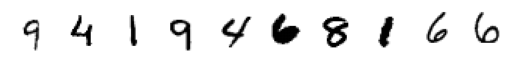

tensor([9, 4, 1, 9, 4, 6, 8, 1, 6, 6])

In [20]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].reshape(28, 28), cmap='gray_r')
plt.show()
y[:10]

### 모델 만들기

In [21]:
# 모델 구조 설계

class MnistNet(nn.Module):
    # 여기서 층을 만들고 ( 모델 구조 설계 1 )
    def __init__(self):     # __init__ 초기화 함수. 
        super(MnistNet, self).__init__()    # 꼭 부모 클래스호출. 부모 클래스한테 내가 누군지 알려주기. 
        self.fc1 = nn.Linear(28*28, 512)    # fully connected = tonsorflow의 Dense. 입력 28*28, 출력 512
        self.fc2 = nn.Linear(512, 256)      # 앞의 출력이 지금의 입력, 출력 256
        self.fc3 = nn.Linear(256, 10)       # 마지막 출력층은 클래스 수와 같아야한다.
        pass
    # 여기서 층을 호출 ( 모델 구조 설계 2 )
    def forward(self, x):   # forward 여기서 모델 훈련. 그래서 입력데이터 받아주는 전달인자 필요
    # view는 numpy의 reshape과 유사. 기능만보면, tensorflow의 flattne(무조건 1차원으로 변환)과 유사. 
    # (view는 무조건 1차원으로 바꾸는건 아님)
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)               # activation 지정: sigmoid, relu, selu, elu 등
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # dim=1: 손실함수 계산하는 방법 지정
        return x                    # 연산 끝난 x 받기
        pass

In [29]:
# 학습 도구 구성
model = MnistNet().to(device)
# loss = nn.CrossEntropyLoss()      # 카테고리 분류시 사용할 손실함수
criterion = nn.CrossEntropyLoss()     # torch 사용자들은 loss보다 criterion이라고 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # learning late(lr) 기본값 0.001

print(model)

MnistNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [30]:
# 훈련 함수 정의 (학습 도구 기반 학습 설계) ( 함수 안 만들고 쭉 써도 된다. ) (tensorflow의 fit)
def train(model, train_loader, optimizer):
    model.train()   # train mode로 설정 > '지금부터 훈련이니까 가중치 업뎃 잘 해줘'라는 의미
    # 얘는 이 작업을 cpu에서 할지 gpu에서 할 지 알려줘야해
    # 모델이 gpu면 데이터도 gpu, 모델이 cpu면 데이터도 cpu
    for idx, (images, labels) in enumerate(train_loader):   # 훈련 log위해서 idx enumerate 설정
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()               # optimizer 초기화
        output = model(images)              # 모델이 학습할 images 주기
        loss = criterion(output, labels)    # 손실 계산을 위한 계산값과 실제값
        loss.backward()                     # 손실을 이용해서 기울기 계산(미분 작업 수행)
        optimizer.step()                    # optimizer가 가중치 업데이트 하라는 것

        if idx % 10 == 0:       # 10번에 한 번씩 log 남기기
            print(f'Batch : {idx}, Loss : {loss.item()}')

In [ ]:
def evaluate(model, test_loader):
    pass

In [31]:
# 학습 실행

for epoch in range(10):
    train(model, train_loader, optimizer)
    print(f"Epoch : {epoch}")

Batch : 0, Loss : 2.2956008911132812
Batch : 10, Loss : 1.804893970489502
Batch : 20, Loss : 1.1296405792236328
Batch : 30, Loss : 0.4146513342857361
Batch : 40, Loss : 0.5767382979393005
Batch : 50, Loss : 0.9247664213180542
Batch : 60, Loss : 0.5314239263534546
Batch : 70, Loss : 0.4477805495262146
Batch : 80, Loss : 0.3840715289115906
Batch : 90, Loss : 0.6523074507713318
Batch : 100, Loss : 0.34213683009147644
Batch : 110, Loss : 0.3414096534252167
Batch : 120, Loss : 0.35961663722991943
Batch : 130, Loss : 0.3211406171321869
Batch : 140, Loss : 0.21568560600280762
Batch : 150, Loss : 0.34215718507766724
Batch : 160, Loss : 0.2767879366874695
Batch : 170, Loss : 0.23577752709388733
Batch : 180, Loss : 0.4802427887916565
Batch : 190, Loss : 0.19961538910865784
Batch : 200, Loss : 0.1893811821937561
Batch : 210, Loss : 0.3712111711502075
Batch : 220, Loss : 0.27417898178100586
Batch : 230, Loss : 0.22022953629493713
Batch : 240, Loss : 0.17919950187206268
Batch : 250, Loss : 0.447300